## MNist Neural Network

The goal is to achieve 99.4% validation/test accuracy, with less than 20k Parameters and in 20 epochs

We start with https://github.com/divya-r-kamat/MnistNN/blob/main/initial-mnist-nn-iteration9.ipynb where we had less tham 25K parameters, but increased the epoch to 20k

### Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

### Model Architecture

In [2]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 28, kernel_size=3)
        self.conv4 = nn.Conv2d(28, 8, kernel_size=1)
        self.conv5 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv6 = nn.Conv2d(16, 28, kernel_size=3)
        self.fc1 = nn.Linear(7 * 7 * 28, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) # 26 x 26 x 16
        x = F.relu(self.conv2(x), 2) # 24 x 24 x 28
        x = F.relu(F.max_pool2d(self.conv3(x), 2))  # 22 x 22 x 28 | 11 x 11 x 28
        x = F.relu(self.conv4(x), 2) # 11 x 11 x 8
        x = F.relu(self.conv5(x), 2) # 9 x 9 x 16
        x = F.relu(self.conv6(x), 2) # 7 x 7 x 28
        x = x.view(-1, 7 * 7 * 28)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

### Check if CUDA is available and display model parameters


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2           [-1, 16, 24, 24]           1,168
            Conv2d-3           [-1, 28, 22, 22]           4,060
            Conv2d-4            [-1, 8, 11, 11]             232
            Conv2d-5             [-1, 16, 9, 9]           1,168
            Conv2d-6             [-1, 28, 7, 7]           4,060
            Linear-7                   [-1, 10]          13,730
Total params: 24,498
Trainable params: 24,498
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.09
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


### Print model architecture

In [4]:
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(28, 8, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(16, 28, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1372, out_features=10, bias=True)
)


### Load train and test data, and apply transformations

In [13]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                    transforms.Resize((28, 28)),
                    transforms.RandomRotation((-15., 15.), fill=0),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])),batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [14]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

### Training Loop

In [15]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Train loss={loss.item():0.4f} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_losses.append(loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Model training

In [17]:

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch 1


Train loss=0.1075 batch_id=468 Accuracy=90.49: 100%|██████████| 469/469 [00:23<00:00, 19.73it/s]


Test set: Average loss: 0.0770, Accuracy: 9765/10000 (97.65%)

Epoch 2


Train loss=0.0600 batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Test set: Average loss: 0.0544, Accuracy: 9817/10000 (98.17%)

Epoch 3


Train loss=0.0453 batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]


Test set: Average loss: 0.0349, Accuracy: 9896/10000 (98.96%)

Epoch 4


Train loss=0.0752 batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]


Test set: Average loss: 0.0350, Accuracy: 9880/10000 (98.80%)

Epoch 5


Train loss=0.0301 batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:24<00:00, 19.21it/s]


Test set: Average loss: 0.0286, Accuracy: 9907/10000 (99.07%)

Epoch 6


Train loss=0.0089 batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]


Test set: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

Epoch 7


Train loss=0.0109 batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]


Test set: Average loss: 0.0312, Accuracy: 9899/10000 (98.99%)

Epoch 8


Train loss=0.0684 batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:23<00:00, 19.62it/s]


Test set: Average loss: 0.0280, Accuracy: 9901/10000 (99.01%)

Epoch 9


Train loss=0.0206 batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:23<00:00, 19.68it/s]


Test set: Average loss: 0.0285, Accuracy: 9910/10000 (99.10%)

Epoch 10


Train loss=0.0094 batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:23<00:00, 19.83it/s]


Test set: Average loss: 0.0246, Accuracy: 9923/10000 (99.23%)

Epoch 11


Train loss=0.1528 batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]


Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

Epoch 12


Train loss=0.0599 batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

Epoch 13


Train loss=0.0381 batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.25%)

Epoch 14


Train loss=0.0058 batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]


Test set: Average loss: 0.0240, Accuracy: 9919/10000 (99.19%)

Epoch 15


Train loss=0.0152 batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

Epoch 16


Train loss=0.0070 batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:23<00:00, 19.86it/s]


Test set: Average loss: 0.0175, Accuracy: 9934/10000 (99.34%)

Epoch 17


Train loss=0.1072 batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 19.21it/s]


Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)

Epoch 18


Train loss=0.0102 batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:23<00:00, 19.89it/s]


Test set: Average loss: 0.0156, Accuracy: 9944/10000 (99.44%)

Epoch 19


Train loss=0.0248 batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]


Test set: Average loss: 0.0162, Accuracy: 9940/10000 (99.40%)

Epoch 20


Train loss=0.0054 batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]


Test set: Average loss: 0.0165, Accuracy: 9939/10000 (99.39%)



### Plots

Text(0.5, 1.0, 'Test Accuracy')

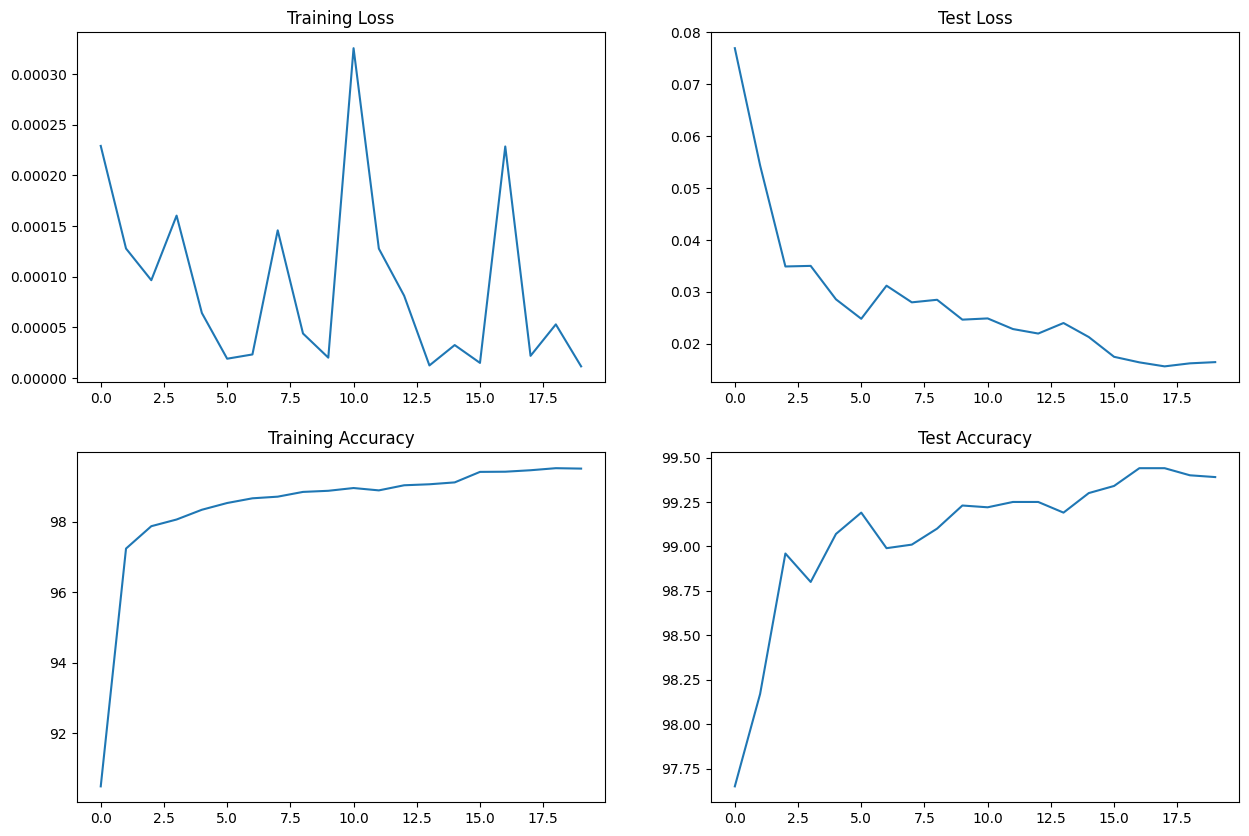

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([loss.cpu().item() for loss in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")